Create a random forest from scratch, based on an exercise in chapter 6 of the excellent book [Hands on Machine Learning with Scikit-learn and Tensorflow](http://shop.oreilly.com/product/0636920052289.do).

## Train and fine tune a Decision Tree for the moons dataset

> a. Generate a moons dataset using `make_moons(n_samples=10000, noise=0.4)`

Reading the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) for the `make_moons` function tells us the following things:

 - It is for making play datasets with for clustering and classification
 - The `n_samples` parameter suggested controls the number of datapoints that it will return
 - `noise` is random noise added to the dataset
 - It is going to return two things: an array `X` containing the samples and an array `y` containing their class

In [1]:
from sklearn.datasets import make_moons

moons_X, moons_y = make_moons(n_samples=10000, noise=0.4)

I like to take a look at the dataset before getting stuck in.
I could try printing it out, or can use the plotting functions in matplotlib.
Plotting is nicer, lets try that.

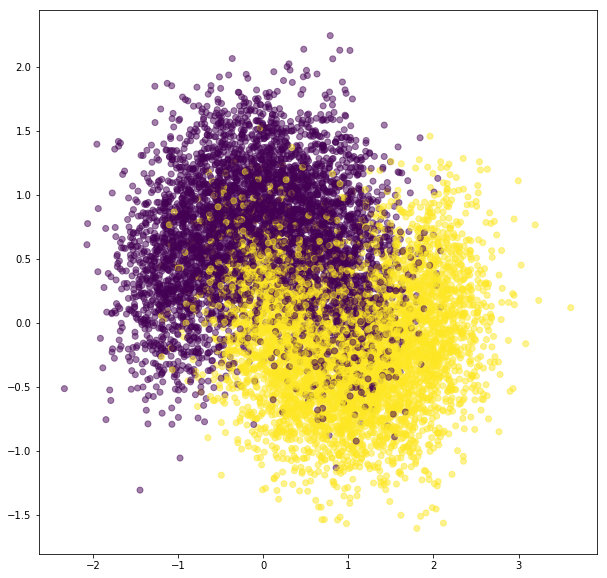

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

figure = plt.figure(figsize=(10, 10))

plt.scatter(
    x=moons_X[:, 0], y=moons_X[:, 1], c=moons_y, alpha=0.5
);

Okay, that makes sense.
There are two classes there, which I'm going to try separating with the decision tree.
There is a bit of overlap between the classes, which is going to make things more difficult for the classifier.
Good. We wouldn't want it to have everything easy now 🙂

Just out of interest,
what happens if we reduced that noise parameter?
I'll create a temporary dataset that I'll throw away after.

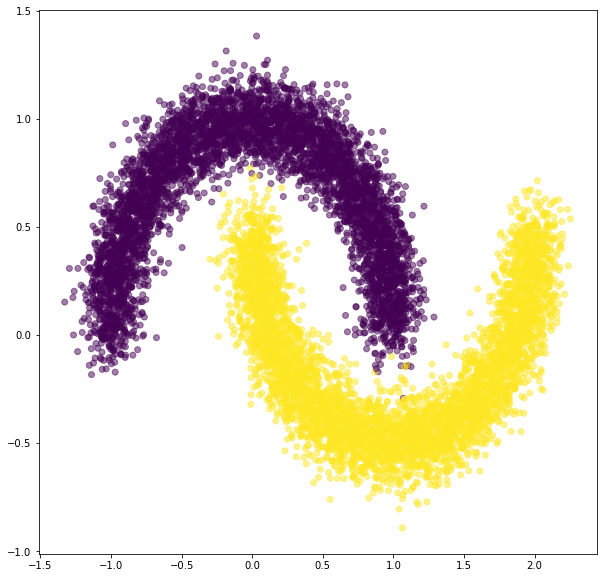

In [3]:
nonoise = make_moons(10000, noise=0.1)

figure = plt.figure(figsize=(10, 10))

plt.scatter(
    x=nonoise[0][:, 0], y=nonoise[0][:, 1], c=nonoise[1], alpha=0.5
);

Okay, makes sense.

> b. Split it into a training set and a test set using `train_test_split()`

Splitting the dataset into a holdout group that we'll use for evaluating the model (_test_ datasets),
and a dataset that we'll use for training the model (_train_ datasets).

Checking the results of your model on a dataset that you didn't use for training is important.
This is a good way to make sure that you're not overfitting your model.
If your model does well on the training dataset,
but poorly on the testing dataset, 
then it probably means that you've overfit your model.

The [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for the `train_test_split` function tells us that it does the following things:

 - You give it parameters like this `train_test_split(*arrays, **options)`. What the single `*` means is that you can pass it in multiple arrays separated by commas, and internally in the function it will treat `arrays` like a list. The double `**` means that you can pass named parameters into the function, separated by commas, and it will treat `options` like a dictionary. I always forget exactly what this means when writing functions myself, but there's a good description on the [saltycrane](http://www.saltycrane.com/blog/2008/01/how-to-use-args-and-kwargs-in-python/) blog.
 
 - One of the options that you can give to it is `test_size`, which defaults to $0.25$. This is the proportion of the datasets that get held back for the testing dataset.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(moons_X, moons_y)

> c. Use grid search with cross-validation (with the help of the `GridSearchCV` class) to find good hyperparameter values for a `DecisionTreeClassifier`. Hint: try various values for `max_leaf_nodes`.

Okay, this is where we start training a model over our data.
The `DecisionTreeClassifier` is the model we're going to use.
There are a bunch of hyperparameters you can select for the decision tree model.
We're only going to be looking at one parameter - the `max_leaf_nodes` parameter.

`GridSearchCV` searches through all the combinations of hyperparameter you give it,
and it finds out which is the best one.
It finds out the best combination is by applying cross validation.
The metric that it [optimises for by default](http://scikit-learn.org/stable/modules/grid_search.html#specifying-an-objective-metric) for a classification algorithm is accuracy
(for regression problems it uses the `r2_score`).

So it runs every combination of hyperparameter,
calculates a cross validated accuracy score (since we're using a classifier),
and finds out which combination is most accuract.
You tell the grid search which combinations of parameter to use by passing it a [param_grid](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
In this case I'll be passing it a dictionary with a range of values from 2 to 10 for the `max_leaf_nodes` parameter.
If I wanted to try more parameters, then I'd add them into that dictionary.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree = DecisionTreeClassifier()
param_grid = {'max_leaf_nodes': range(2, 10)}

cv = GridSearchCV(tree, param_grid)
cv.fit(X=X_train, y=y_train)

print(cv.best_params_)
print(cv.best_score_)

{'max_leaf_nodes': 4}
0.846


> d. Train it on the full training set using these hyperparameters, and measure your model's performance on the test set. You should get roughly $85\%$ to $87\%$ accuracy.

So now take the hyperparameters that were taken from above,
train a model with those hyperparameters,
and then compare it against that holdout group from above.

In [21]:
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier(max_leaf_nodes=4)
tree.fit(X=X_train, y=y_train)

y_pred = tree.predict(X=X_test)

decisiontree_accuracy = accuracy_score(y_test, y_pred)
decisiontree_accuracy

0.85240000000000005

## Grow a forest

> a. Continuing the previous excercise, generate 1,000 subsets of the training set, each containing 100 instances selected randomly. Hint: you can use Scikit-Learn's `ShuffleSplit` for this.

In [7]:
from sklearn.model_selection import ShuffleSplit

shuffler = ShuffleSplit(n_splits=1000, test_size=0, train_size=100)
subsets = []
for train_index, test_index in shuffler.split(X_train):
    subsets.append((X_train[train_index], y_train[train_index]))

> b. Train on Decision Tree on this subset, using the best hyperparameter values found above. Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree, achieving only about 80% accuracy.

I need to make a tree for every subset of the data that I've created.

I really like the `tqdm` for anything where I'm iterating over a lot of things.
It makes it really easy to put a progress bar in.

In [8]:
import tqdm
trees = []
for subset in tqdm.tqdm(subsets):
    tree = DecisionTreeClassifier(max_leaf_nodes=4)
    tree.fit(subset[0], subset[1])
    trees.append(tree)    

100%|██████████| 1000/1000 [00:00<00:00, 1862.05it/s]


Now evaluate the accuracy for each of these subtrees against the test dataset,
calculating the accuracy score.

In [9]:
accuracies = [accuracy_score(y_test, tree.predict(X_test)) for tree in trees]

Indeed it does look like our mean accuracy for each of the subtrees against the test set is poorer than the accuracy of the big decision tree.

0.8282456
0.8524


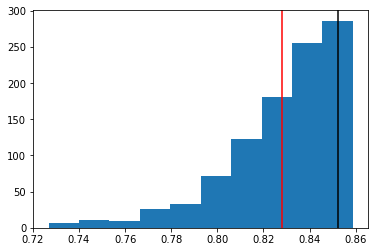

In [27]:
import numpy as np
mean_subtree_accuracy = np.mean(accuracies)

print(mean_subtree_accuracy)
print(decisiontree_accuracy)

plt.hist(accuracies)
plt.axvline(np.mean(accuracies), color='red')
plt.axvline(decisiontree_accuracy, color='black');

> c. Now comes the magic. For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy's `mode()` function for this). This gives you the _majority-vote predictions_ over the test set.

In [28]:
predictions = []
for tree in trees:
    prediction = tree.predict(X_test)
    predictions.append(prediction)
    
predictions = np.array(predictions)

In [29]:
import numpy as np
from scipy.stats import mode
majority_vote = mode(np.array(predictions))[0]

> d. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first mode (about 0.5 to 1.5% higher). Congratulations, you have trained a Random Forest classifier!

In [34]:
majority_vote_accuracy = accuracy_score(y_test, majority_vote[0, :])
print(majority_vote_accuracy)
print(decisiontree_accuracy)

print("Improvement {delta}%".format(delta=(majority_vote_accuracy - decisiontree_accuracy)*100))

0.8596
0.8524
Improvement 0.7199999999999984%


It works!